In [15]:
import os
import pandas as pd
import joblib

In [16]:
# Download dataset

import kagglehub

dataset_path = kagglehub.dataset_download("borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", dataset_path)

Path to dataset files: /home/raphael/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


In [17]:
dataset_path += "/Stocks"

# List to store individual DataFrames
dataframes = []

# Iterate through all files in the directory
for file_name in os.listdir(dataset_path):
    # Only process .txt files
    if file_name.endswith('.txt'):
        file_path = os.path.join(dataset_path, file_name)
        
        if len(open(file_path).read()) == 0:
            continue
        
        # Read the file into a DataFrame, assuming the first line is the header
        df = pd.read_csv(file_path)
        
        # Add a 'Stock' column to store the stock symbol (derived from file name)
        df['Stock'] = file_name.split('.')[0]
        
        # Drop the 'OpenInt' column since it's not necessary for the analysis
        df = df.drop(columns=['OpenInt'])
        
        # Append to the list of DataFrames
        dataframes.append(df)

# Combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

# Display a summary of the combined DataFrame
print(f"Combined DataFrame shape: {combined_df.shape}")
print(combined_df.head())

Combined DataFrame shape: (14887665, 7)
         Date   Open   High    Low  Close   Volume Stock
0  2012-02-17  14.50  15.76  14.00  14.30  4350701  bcov
1  2012-02-21  14.47  15.15  14.20  15.15   527691  bcov
2  2012-02-22  15.50  15.50  14.51  14.84   205141  bcov
3  2012-02-23  14.57  15.20  14.50  14.95   102394  bcov
4  2012-02-24  15.02  15.20  14.67  15.10    60574  bcov


In [18]:
# Find out starting and ending date for this dataset

sorted_df = combined_df.sort_values('Date')
start_date = sorted_df.head(1)['Date'].item()
end_date = sorted_df.tail(1)['Date'].item()

print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")

Start Date: 1962-01-02
End Date: 2017-11-10


In [19]:
# Check for missing values
print(combined_df.isnull().sum())

# Check for duplicates
duplicates = combined_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If duplicates exist, drop them
combined_df = combined_df.drop_duplicates()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Stock     0
dtype: int64
Number of duplicate rows: 0


In [20]:
# Convert 'Date' column to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

print(combined_df.dtypes)

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Stock             object
dtype: object


In [21]:
# Add derived features
combined_df['Year'] = combined_df['Date'].dt.year
combined_df['Month'] = combined_df['Date'].dt.month
combined_df['DayOfWeek'] = combined_df['Date'].dt.day_name()
combined_df['DailyReturn'] = combined_df.groupby('Stock')['Close'].pct_change() * 100
combined_df = combined_df.dropna(subset=['DailyReturn'])

IsElectionYear
0    0.204265
1    0.177904
Name: DailyReturn, dtype: float64


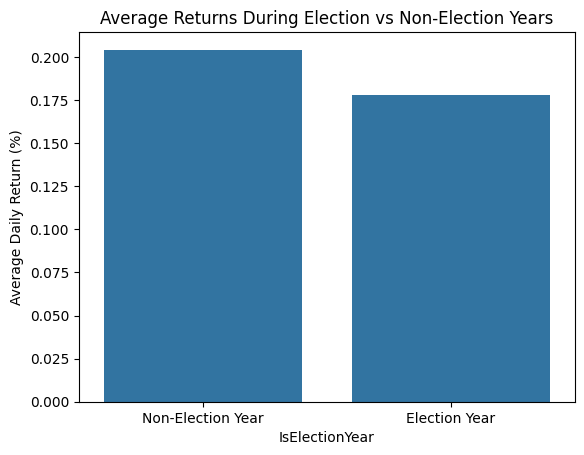

In [22]:
election_years = [1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022, 2024]

combined_df['IsElectionYear'] = combined_df['Year'].apply(lambda x: 1 if x in election_years else 0)

# Compare average returns during election years vs. non-election years
election_returns = combined_df.groupby('IsElectionYear')['DailyReturn'].mean()
print(election_returns)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=election_returns.index, y=election_returns.values)
plt.xticks([0, 1], ['Non-Election Year', 'Election Year'])
plt.ylabel('Average Daily Return (%)')
plt.title('Average Returns During Election vs Non-Election Years')
plt.show()

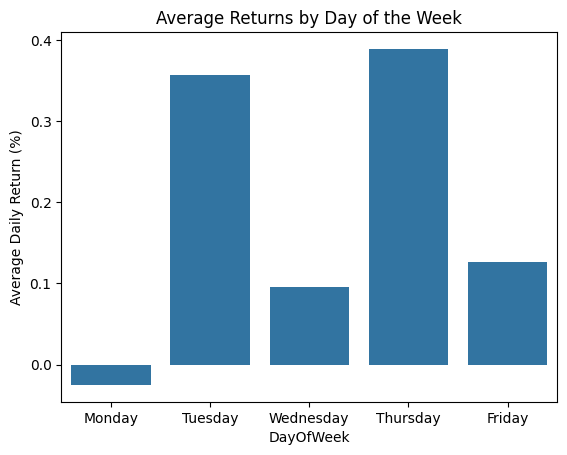

In [23]:
# Average return by day of the week
day_of_week_returns = combined_df.groupby('DayOfWeek')['DailyReturn'].mean()

# Visualization
sns.barplot(x=day_of_week_returns.index, y=day_of_week_returns.values, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.ylabel('Average Daily Return (%)')
plt.title('Average Returns by Day of the Week')
plt.show()

In [24]:
# Select subset of rows
sampled_df = combined_df.sample(frac=0.05, random_state=42)

In [25]:
# Save dataframe so streamlit can access it
sampled_df.to_csv('combined_df.csv', index=False)

Predicting Stock Returns by Day of Week

In [30]:
# Add day of the week
sampled_df['DayOfWeek'] = sampled_df['Date'].dt.dayofweek  # Monday=0, Sunday=6

In [31]:
# Select features and target
X = sampled_df[['DayOfWeek']]
y = sampled_df['DailyReturn']

# One-hot encode DayOfWeek for models that benefit from categorical features
X = pd.get_dummies(X, columns=['DayOfWeek'], prefix='Day')

In [32]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

joblib.dump(model, 'DayOfWeek_LinearRegression.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved.")
print(f"Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

Model trained and saved.
Mean Absolute Error: 1.8422140255883634
R Squared Value: -0.0007760176320321666


Using lagged features

In [24]:
# Add lagged features
for lag in range(1, 6):  # Lagging 1-5 days
    sampled_df[f'Lag_{lag}'] = sampled_df.groupby('Stock')['Close'].shift(lag)

# Add rolling averages
sampled_df['MA_5'] = sampled_df.groupby('Stock')['Close'].rolling(window=5).mean().reset_index(0, drop=True)
sampled_df['MA_10'] = sampled_df.groupby('Stock')['Close'].rolling(window=10).mean().reset_index(0, drop=True)

# Drop rows with missing values after lagging
sampled_df = sampled_df.dropna()

In [25]:
# Select features and target
features = [f'Lag_{i}' for i in range(1, 6)] + ['MA_5', 'MA_10', 'DayOfWeek']
X = sampled_df[features]
y = sampled_df['DailyReturn']

# One-hot encode DayOfWeek for categorical modeling
X = pd.get_dummies(X, columns=['DayOfWeek'], prefix='Day')

In [26]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

joblib.dump(model, 'DayOfWeek_LinearRegression.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved.")
print(f"Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

Model trained and saved.
Mean Absolute Error: 3.1967294862489033
R Squared Value: -1.745405303621439e-06


In [28]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

model = GradientBoostingRegressor(n_estimators=100, random_state=42, verbose=True)
model.fit(X_train, y_train)

joblib.dump(model, 'GradientBoostingRegressor_DayOfWeek.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved.")
print(f"Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

      Iter       Train Loss   Remaining Time 
         1          18.8478            9.88m
         2          18.8455            9.75m
         3          18.8433            9.64m
         4          18.8368            8.57m
         5          18.8350            8.64m
         6          18.8298            8.66m
         7          18.8266            8.63m
         8          18.7898            8.58m
         9          18.7877            8.14m
        10          18.7872            8.13m
        20          18.7148            7.15m
        30          18.6658            6.35m
        40          18.6456            5.41m
        50          18.6278            4.49m
        60          18.6195            3.59m
        70          18.5831            2.69m
        80          18.5665            1.80m
        90          18.5408           54.01s
       100          18.5187            0.00s
Model trained and saved.
Mean Absolute Error: 3.199086969787665
R Squared Value: -2.469678631822347

Predicting Stock Returns by Future Dates

In [12]:
from sklearn.model_selection import train_test_split

# Select features and target
features = ['Open', 'High', 'Low', 'Volume', 'Lag_1', 'Lag_2', 'Lag_3', 'MA_5', 'MA_10']
target = 'DailyReturn'

# Train-test split
X = sampled_df[features]
y = sampled_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

joblib.dump(model, 'Future_LinearRegression.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved.")
print(f"Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

Model trained and saved. Mean Absolute Error: 1.8113611293037268
R Squared Value: 4.225662252987927e-05


In [17]:
# Using gradient boosting

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

joblib.dump(model, 'GradientBoostingRegressor.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved. Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

KeyboardInterrupt: 

In [ ]:
# Using random forest

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42, n_estimators=100,
                              n_jobs=-1 # use max number of cores
)
model.fit(X_train, y_train)

joblib.dump(model, 'RandomForestRegressor.pkl')

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Model trained and saved. Mean Absolute Error: {mae}")
print(f"R Squared Value: {r2}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the parameter grid
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(3, 20),
}

model = RandomForestRegressor(random_state=42)

# Use RandomizedSearchCV to find the best hyperparameters
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

# Get the best model
best_model = search.best_estimator_